© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import cvxopt
import time 

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

# 🧪 Homework 8 — SVM with Spectrum Kernel on Gene Sequence Data

The goal of this exercise is to apply kernel SVM with the **spectrum kernel** to classify DNA sequences from the **UCI Splice-junction Gene Sequences** dataset.

## 🧬 Load and Preprocess Data

DNA sequences are composed of four nucleotide bases:

> **A**, **T**, **C**, **G**

However, according to the [dataset description](https://archive.ics.uci.edu/dataset/69/molecular+biology+splice+junction+gene+sequences), some sequences include **ambiguous characters** such as:

> **D**, **N**, **S**, **R**

These represent uncertain letters in a given position.

Since these ambiguous characters occur **infrequently**, we will simplify preprocessing by **removing all sequences** that contain any ambiguous characters.

In [2]:
file_name = 'splice.data'

with open(file_name, 'r') as f:
    lines = f.readlines()
    labels = []
    X = []

    for line in lines:
        parts = line.strip().split(',')

        ambiguous_chars = {"D", "N", "S", "R"}
        if any(c in parts[-1] for c in ambiguous_chars): 
            continue
        X.append(parts[-1].strip())  
        labels.append(parts[0])

    label_map = {'EI': 1, 'IE': -1, 'N': -1}  # Binary: exon-intron vs others
    Y = np.array([label_map[l] for l in labels])
    X = np.array(X)

## Spectrum Kernel 

The **spectrum kernel** of order $k$ compares sequences by counting how many substrings of length $k$ (called $k$-mers) they share.

>**Definition**:
>
>Let $\Phi_k(s)$ be the vector of $k$-mer counts for a sequence $s$. Then:
>
>$$
>K_k(s_i, s_j) = \langle \Phi_k(s_i), \Phi_k(s_j) \rangle
>= \sum_{u \in \mathcal{A}^k} \text{count}_u(s_i) \cdot \text{count}_u(s_j)
>$$
>
>Where:
>- $\mathcal{A} = \{A, C, G, T\}$
>- $\text{count}_u(s)$ is the number of times the $k$-mer $u$ appears in sequence $s$

We implement this kernel below.

In [3]:
import itertools 

class SpectrumKernel:
    def __init__(self, k, X):
        self.k = k
        vocab = {c for seq in X for c in seq}
        self.kmers = [''.join(kmer) for kmer in itertools.product(vocab, repeat=k)]

    def feature_map(self, X):
        Phi = np.zeros((len(X), len(self.kmers)))
        for i, seq in enumerate(X):
            for j, kmer in enumerate(self.kmers):
                count = seq.count(kmer)
                Phi[i, j] = count

        return Phi


    def __call__(self, X1, X2):
        Phi1 = self.feature_map(X1)
        Phi2 = self.feature_map(X2)
        return Phi1 @ Phi2.T


Our implementation:
- generates the vocabulary from a dataset `X` on initialization of the kernel class,
- uses `itertools.product` function to generate all the possible combinations of $k$ symbols from the vocabulary,
- uses in-built `str.count` function to count the number of times a $k$-mer occurs in a DNA string. 

## Train and Evaluate Kernel SVM

In [4]:
from courselib.utils.splits import train_test_split_np
from courselib.models.svm import BinaryKernelSVM

training_data_fraction = .8

X_train, Y_train, X_test, Y_test = train_test_split_np(X, Y)

In [5]:
from courselib.utils.metrics import binary_accuracy

k_vals = list(range(1, 9))
k_test_acc = []
k_train_acc = []
k_train_time = []

for k in k_vals:
    print(f'k={k}')
    start = time.time()
    svm = BinaryKernelSVM(kernel='custom', 
                          kernel_function=SpectrumKernel(k=k, X=X))
    svm.fit(X_train, Y_train)
    end = time.time()
    
    test_acc = binary_accuracy(svm(X_test), Y_test)
    k_test_acc.append(test_acc)

    train_acc = binary_accuracy(svm(X_train), Y_train)
    k_train_acc.append(train_acc)
    print(f'Test accuracy: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start
    k_train_time.append(train_time)
    print(f"⏱️ Train time: {train_time:.4f} seconds")

k=1
Test accuracy: 77.4448, Train accuracy: 75.6395
⏱️ Train time: 3.6511 seconds
k=2
Test accuracy: 77.4448, Train accuracy: 75.6395
⏱️ Train time: 5.5875 seconds
k=3
Test accuracy: 82.6498, Train accuracy: 81.3459
⏱️ Train time: 6.1232 seconds
k=4
Test accuracy: 86.5931, Train accuracy: 89.5710
⏱️ Train time: 6.2914 seconds
k=5
Test accuracy: 85.8044, Train accuracy: 99.6458
⏱️ Train time: 5.7808 seconds
k=6
Test accuracy: 89.2744, Train accuracy: 100.0000
⏱️ Train time: 9.1530 seconds
k=7
Test accuracy: 89.4322, Train accuracy: 100.0000
⏱️ Train time: 25.4522 seconds
k=8
Test accuracy: 86.9085, Train accuracy: 100.0000
⏱️ Train time: 97.3295 seconds


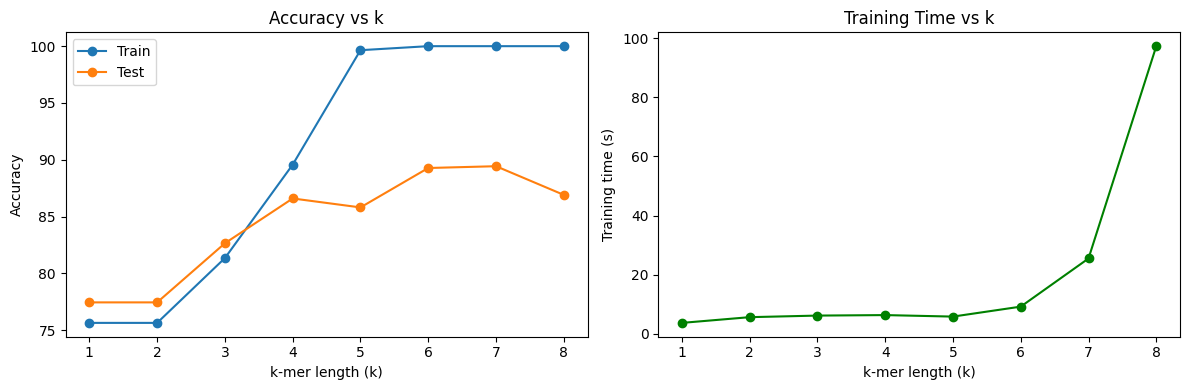

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_vals[:len(k_test_acc)], k_train_acc, label='Train', marker='o')
plt.plot(k_vals[:len(k_test_acc)], k_test_acc, label='Test', marker='o')
plt.xlabel("k-mer length (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_vals[:len(k_train_time)], k_train_time, marker='o', color='green')
plt.xlabel("k-mer length (k)")
plt.ylabel("Training time (s)")
plt.title("Training Time vs k")

plt.tight_layout()
plt.show()
